In [ ]:
 !pip3 install torch torchvision

In [ ]:
!pip install imagecorruptions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.6 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
import imgaug as ia
from imgaug import augmenters as iaa
from google.colab.patches import cv2_imshow


In [ ]:
ls

sample_data/


In [ ]:
import numpy
numpy.version.version

'1.23.5'

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'training'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
# sys.path.append('/content/drive/{}')

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
# %cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
# !bash get_datasets.sh
# %cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/$FOLDERNAME/
# %cd /content/drive/$FOLDERNAME/

/content/drive/My Drive/training


In [ ]:
# !wget https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz

## Download Original Dataset

In [ ]:
# !tar xvzf CUB_200_2011.tgz

In [ ]:
# !cat CUB_200_2011/README

In [ ]:
# %cd drive/$FOLDERNAME

In [ ]:
# cd drive/MyDrive/CS682Project

## Import required libraries

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


In [ ]:
import albumentations as A

## Helper Functions

read_image() functions reads image and converts it from BGR to RGB as opencv used BGR while matplotlib uses RGB. So, we need to make this conversion so we can easily visualize the data



In [ ]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [ ]:
# Data Augmentation
import math



In [ ]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im/255.0 - imagenet_stats[0])/imagenet_stats[1]

In [ ]:
pwd

'/content/drive/My Drive/training'

In [ ]:
PATH = Path('./dataset/CUB_200_2011')
labels = pd.read_csv(PATH/"image_class_labels.txt", header=None, sep=" ")
labels.columns = ["id", "label"]
train_test = pd.read_csv(PATH/"train_test_split.txt", header=None, sep=" ")
train_test.columns = ["id", "is_train"]
images = pd.read_csv(PATH/"images.txt", header=None, sep=" ")
images.columns = ["id", "name"]

In [ ]:
def apply_transform_blur(x, sz=(224, 224)):
    """Create an augmenter that always pools with a kernel size of 2 x 2"""
    transform = iaa.Sequential([
      iaa.imgcorruptlike.GaussianBlur(severity=2),
      iaa.Resize({"height": sz[0], "width": sz[1]})
    ])
    #passed the image x to the transform function
    x = transform(image=x)
    # cv2_imshow(x)
    #extracted the transformed image from the dictionary returned by the transformation using the key 'image'
    return x

In [ ]:
class CUBImageCorrupt(Dataset):
    def __init__(self, files_path, labels, train_test, image_name, train=True,
                 transform=False):

        self.files_path = files_path
        self.labels = labels
        self.transform = transform
        self.train_test = train_test
        self.image_name = image_name

        if train:
          mask = self.train_test.is_train.values == 1

        else:
          mask = self.train_test.is_train.values == 0


        self.filenames = self.image_name.iloc[mask]
        self.labels = self.labels[mask]
        self.num_files = self.labels.shape[0]



    def __len__(self):
        return self.num_files

    def __getitem__(self, index):
        y = self.labels.iloc[index,1] - 1

        file_name = self.filenames.iloc[index, 1]
        path = self.files_path/'images'/file_name
        x = read_image(path)
        x = apply_transform_blur(x)
        # After reading and transforming the image:
        if x.shape[1:] != (224, 224):
          x = cv2.resize(x, (224, 224))
        x = normalize(x)
        x =  np.rollaxis(x, 2) # To meet torch's input specification(c*H*W)
        return x,y

In [ ]:
class CUB(Dataset):
    def __init__(self, files_path, labels, train_test, image_name, train=True,
                 transform=False):

        self.files_path = files_path
        self.labels = labels
        self.transform = transform
        self.train_test = train_test
        self.image_name = image_name

        if train:
          mask = self.train_test.is_train.values == 1

        else:
          mask = self.train_test.is_train.values == 0


        self.filenames = self.image_name.iloc[mask]
        self.labels = self.labels[mask]
        self.num_files = self.labels.shape[0]



    def __len__(self):
        return self.num_files

    def __getitem__(self, index):
        y = self.labels.iloc[index,1] - 1

        file_name = self.filenames.iloc[index, 1]
        path = self.files_path/'images'/file_name
        x = read_image(path)
        x = cv2.resize(x, (224,224))
        x = normalize(x)
        x =  np.rollaxis(x, 2) # To meet torch's input specification(c*H*W)
        return x,y

In [ ]:
train_dataset = CUB(PATH, labels, train_test, images, train= True, transform= True)

In [ ]:
val_dataset = CUB(PATH, labels, train_test, images, train= False, transform= True)
baseline_val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=2)

In [ ]:
train_dataset_blurred = CUBImageCorrupt(PATH, labels, train_test, images, train= False, transform= True)

In [ ]:
concat_train_dataset = ConcatDataset((train_dataset, train_dataset_blurred))
augmented_train_loader = DataLoader(concat_train_dataset, batch_size=64, shuffle=True, num_workers=2)

In [ ]:
print(len(train_dataset),len(concat_train_dataset))

5994 11788


In [ ]:
pwd

'/content/drive/My Drive/training'

In [ ]:
# Function for calculating metrics
def metrics(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device).float(), labels.to(device).long()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, pred = torch.max(outputs, 1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
            sum_loss += loss.item() * labels.size(0)
    return sum_loss / total, correct / total

In [ ]:
# Check for available CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

# Model Architecture
resnet50 = models.resnet50(pretrained=True).to(device)

# Freeze layers
for param in resnet50.parameters():
    param.requires_grad = False

num_of_classes = len(np.unique(train_dataset.labels['label']))

# Modify last layer
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, num_of_classes).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s]


Define Model(ResNet50).

In [32]:
# Training Loop
for epoch in range(10):
  resnet50.train()
  for inputs, labels in augmented_train_loader:
    inputs, labels = inputs.to(device).float(), labels.to(device).long()
    optimizer.zero_grad()
    outputs = resnet50(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  # Training metrics
  train_loss, train_acc = metrics(resnet50, augmented_train_loader)
  train_losses.append(train_loss)
  train_accuracy.append(train_acc)

  # Validation metrics
  val_loss, val_acc = metrics(resnet50, baseline_val_loader)
  val_losses.append(val_loss)
  val_accuracy.append(val_acc)

  print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')

# Save the model
torch.save(resnet50.state_dict(), './model_weights/resnet50_cub_blur_2n.pth')



Output hidden; open in https://colab.research.google.com to view.

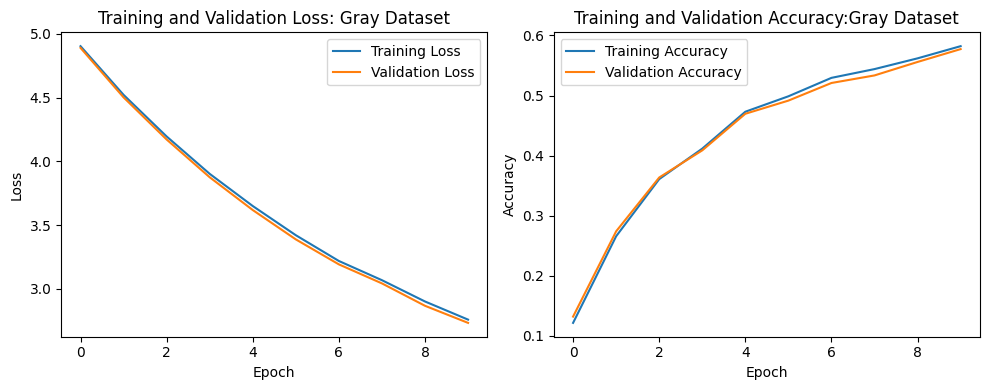

In [33]:
# Plotting
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Training and Validation Loss: Gray Dataset")
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Training and Validation Accuracy:Gray Dataset")
plt.plot(train_accuracy, label="Training Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [34]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [35]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    #with torch.no_grad():
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        # correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)

        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [36]:
def calc_accuracy(model, dataloader):
    model.eval()
    model.cuda()

    top1 = AverageMeter()
    top5 = AverageMeter()

    for idx, (inputs, labels) in enumerate(dataloader):

        inputs, labels = inputs.cuda().float(), labels.cuda().long()
        # obtain the outputs from the model
        outputs = model.forward(inputs)
        prec1, prec5 = accuracy(outputs, labels, topk=(1, 5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))

    return top1 ,top5

In [37]:
# Initialize the model architecture
resnet50 = models.resnet50(pretrained=False)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, num_of_classes)  # Replace with your number of classes

# Load the saved state dictionary
resnet50.load_state_dict(torch.load('./model_weights/resnet50_cub_blur_2n.pth'))

# Move to appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet50 = resnet50.to(device)

# Set to evaluation mode
resnet50.eval()
# Run inference

top1 ,top5 = calc_accuracy(resnet50, baseline_val_loader)
print("top1 avg", top1.avg)
print("top5 avg",top5.avg)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


top1 avg tensor(57.7321, device='cuda:0')
top5 avg tensor(85.4850, device='cuda:0')


In [38]:
from sklearn.metrics import classification_report
import numpy as np

# # Switch model to evaluation mode
# resnet50.eval()

# Store all predictions and true labels
all_preds = []
all_labels = []

# Loop through validation data
with torch.no_grad(): # No need to compute gradients when evaluating
    for inputs, labels in baseline_val_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device).long()

        # Forward pass
        outputs = resnet50(inputs)

        # Get the predicted class labels
        _, preds = torch.max(outputs, 1)

        # Append to lists
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Generate classification report
report = classification_report(all_labels, all_preds)
# print(report)

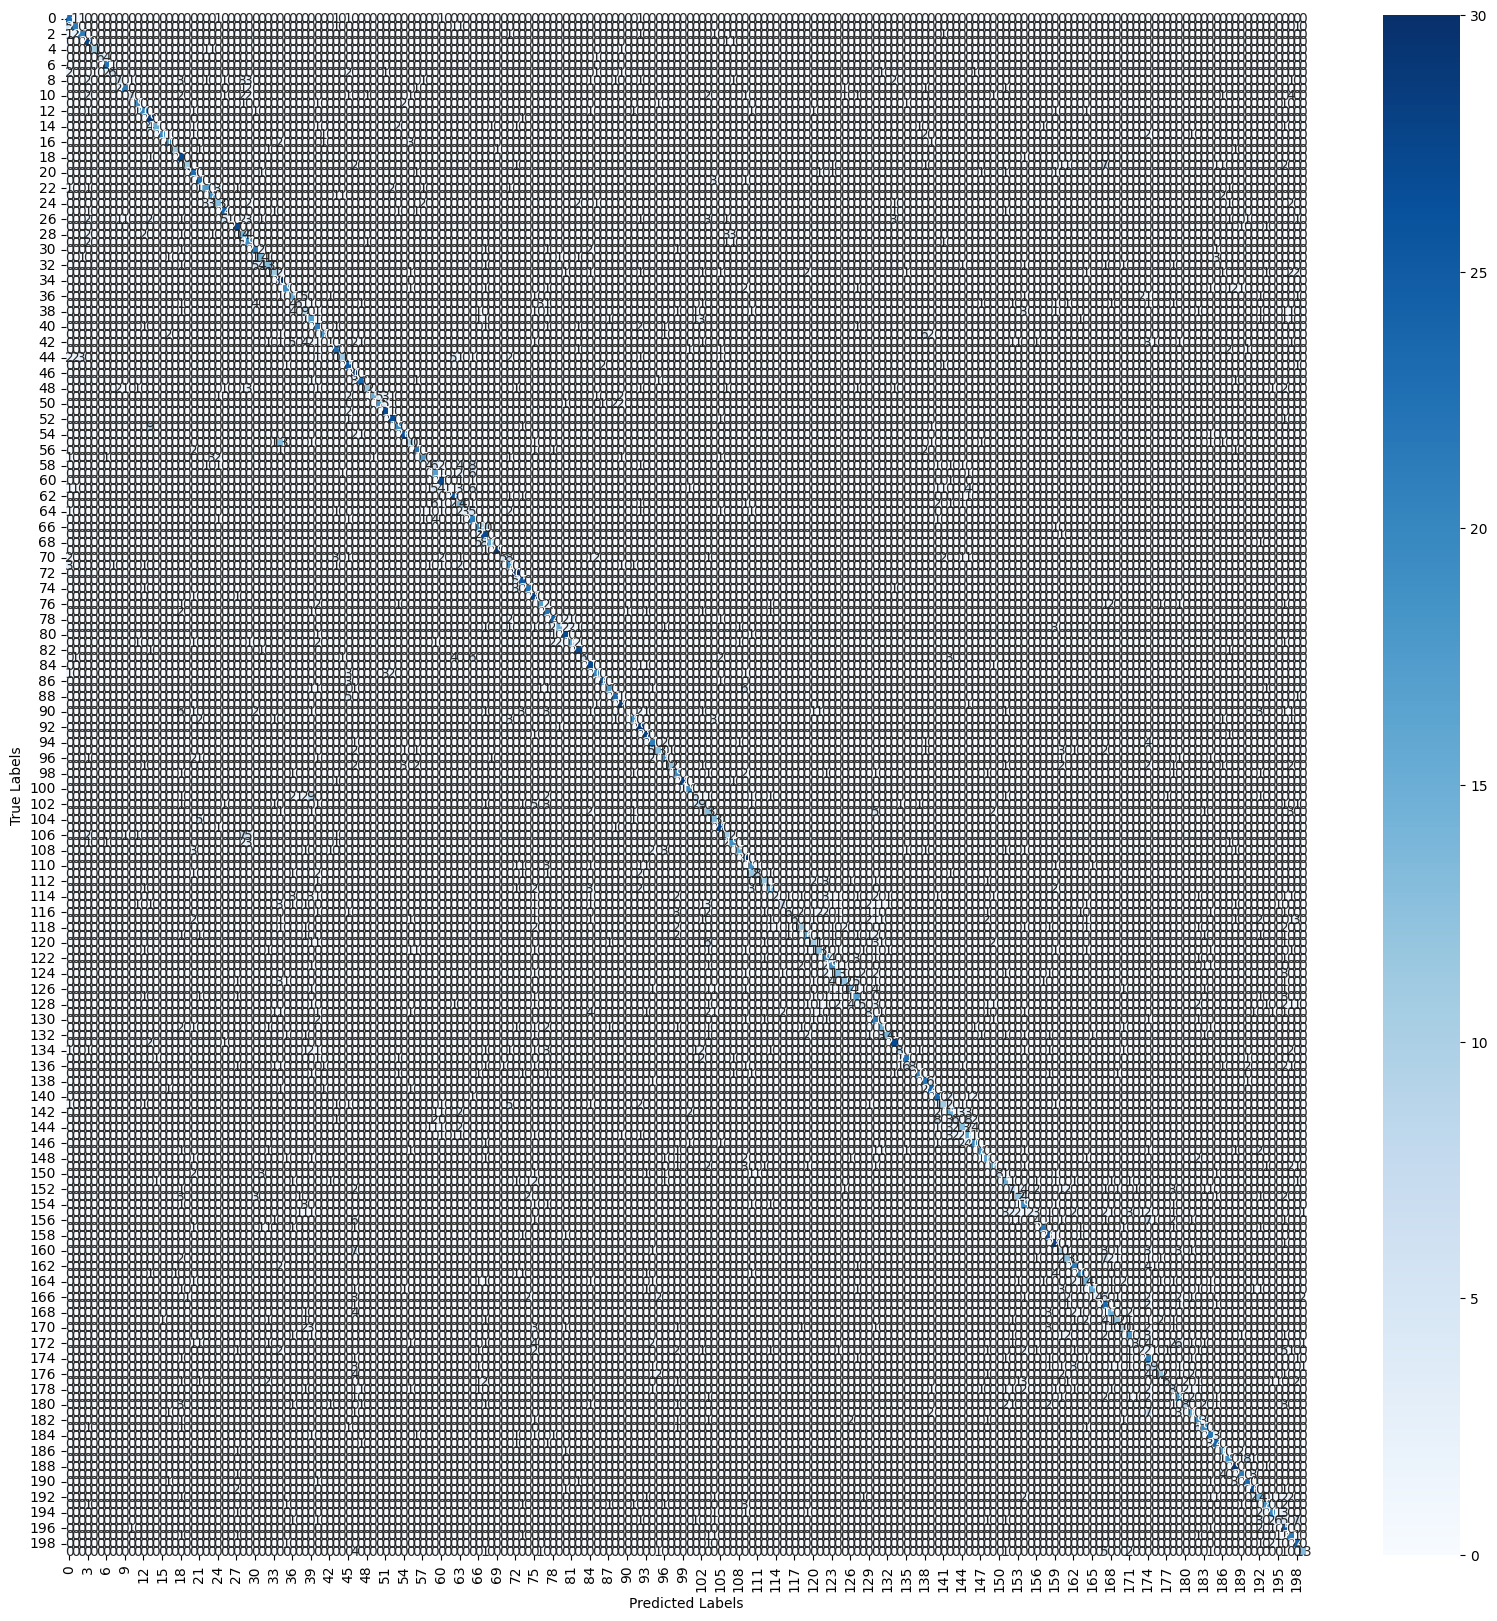

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)



plt.figure(figsize=(20, 20))  # You may want to adjust this based on how many classes you have
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [40]:
#t-sne map for feature space visualization of validation set
from sklearn.manifold import TSNE

embeddings = []
labels_list = []

def extract_embeddings(model, loader):
    with torch.no_grad():
        for inputs, labels in loader:
            # inputs = inputs.to(device)
            inputs = inputs.to(device).float()


            # Forward pass to get the embeddings before the final layer
            x = model.conv1(inputs)
            x = model.bn1(x)
            x = model.relu(x)
            x = model.maxpool(x)
            x = model.layer1(x)
            x = model.layer2(x)
            x = model.layer3(x)
            x = model.layer4(x)
            x = model.avgpool(x)
            embedding = torch.flatten(x, 1)

            embeddings.append(embedding.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    return np.vstack(embeddings), np.concatenate(labels_list)

embeddings, labels = extract_embeddings(resnet50, baseline_val_loader)


tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

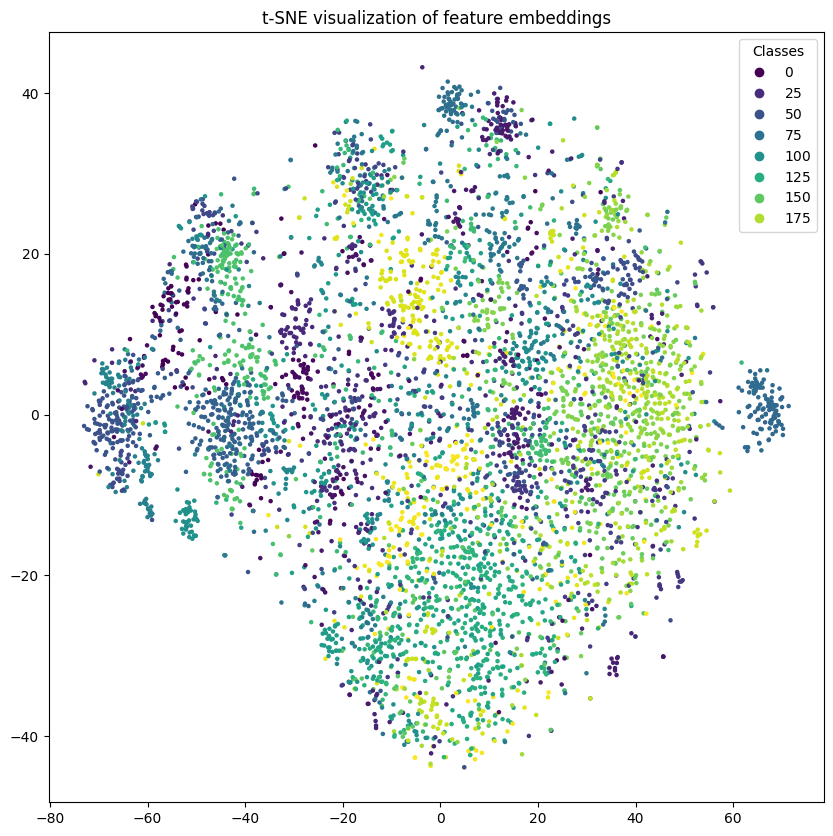

In [41]:
plt.figure(figsize=(10,10))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', s=5)
legend = plt.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
# plt.add_artist(legend)
plt.title("t-SNE visualization of feature embeddings")
plt.show()

In [42]:
#top confused pairs -10
def get_top_confused_classes(confusion_matrix, num_pairs=10):
    # Get indices of non-diagonal values (i.e., exclude true positives)
    rows, cols = np.where(np.triu(confusion_matrix, 1) > 0)

    # Get the values at these indices
    confusions = confusion_matrix[rows, cols]

    # Sort them in descending order
    sorted_indices = np.argsort(confusions)[::-1]

    # Get the top confused pairs and their values
    top_rows = rows[sorted_indices][:num_pairs]
    top_cols = cols[sorted_indices][:num_pairs]
    top_values = confusions[sorted_indices][:num_pairs]

    return top_rows, top_cols, top_values

top_rows, top_cols, top_values = get_top_confused_classes(cm, num_pairs=10)
top_confused_pairs = list(zip(top_rows, top_cols, top_values))
top_confused_pairs
#class x, class y, number of times model was confused
# we can conduct visual similarity check, data distribution for class imbalance, sample review, aggresive regularization/augmentation.

[(66, 67, 10),
 (187, 190, 8),
 (143, 145, 8),
 (58, 65, 8),
 (70, 71, 8),
 (161, 167, 7),
 (19, 167, 7),
 (156, 174, 7),
 (195, 198, 7),
 (172, 179, 6)]

Validation Metric